In [1]:
from sdo.sood.data.sdo_ml_v2_dataset import SDOMLv2DataModule

/home/marius/sdo-cli/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pathlib import Path
import numpy as np
import os 
import sunpy
from sunpy.visualization.colormaps import cm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torchvision
import torch
import torchvision.transforms.functional as F

#inspect an image

#Channels that correspond to HMI Magnetograms 
HMI_WL = ['Bx','By','Bz']
#A colormap for visualizing HMI
HMI_CM = LinearSegmentedColormap.from_list("bwrblack", ["#0000ff","#000000","#ff0000"])

def channel_to_map(name):
    """Given channel name, return colormap"""
    return HMI_CM if name in HMI_WL else cm.cmlist.get('sdoaia%d' % int(name))

def get_clip(X,name):
    """Given an image and the channel name, get the right clip"""
    return get_signed_pct_clip(X) if name in HMI_WL else get_pct_clip(X)

def get_pct_clip(X):
    """Return the 99.99th percentile"""
    return (0,np.quantile(X.ravel(),0.999))

def get_signed_pct_clip(X):
    """Return the 99.99th percentile by magnitude, but symmetrize it so 0 is in the middle"""
    v = np.quantile(np.abs(X.ravel()),0.999)
    return (-v,v)

def vis(X, cm, clip):
    """Given image, colormap, and a clipping, visualize results"""
    Xc = np.clip((X-clip[0])/(clip[1]-clip[0]),0,1)
    Xcv = cm(Xc)
    return (Xcv[:,:,:3]*255).astype(np.uint8)

def show_grid(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(figsize=(24,24), ncols=4, nrows=int(len(imgs)/4), squeeze=False)
    row = 0
    for i, img in enumerate(imgs):
        col = i % 4
        if i != 0 and i % 4 == 0:
            row = row + 1
        axs[row, col].imshow(img)
        axs[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

In [15]:
loader = SDOMLv2DataModule("/mnt/nas05/astrodata01/astroml_data/sdomlv2.zarr", storage_driver="fs", train_year=["2010"], channel="193A", train_start="2010-08-27 00:00:00", train_end="2010-08-28 23:59:59", test_start="2010-08-29 00:00:00",
                           test_end="2010-08-29 23:59:59", train_val_split_temporal_chunk_size="1h", prefetch_factor=2).train_dataloader()


discovered the following zarr directory structure
/
 ├── 2010
 │   ├── 131A (47116, 512, 512) float32
 │   ├── 1600A (47972, 512, 512) float32
 │   ├── 1700A (46858, 512, 512) float32
 │   ├── 171A (47186, 512, 512) float32
 │   ├── 193A (47134, 512, 512) float32
 │   ├── 211A (47186, 512, 512) float32
 │   ├── 304A (47131, 512, 512) float32
 │   ├── 335A (47187, 512, 512) float32
 │   └── 94A (46930, 512, 512) float32
 ├── 2011
 │   ├── 131A (75200, 512, 512) float32
 │   ├── 1600A (75814, 512, 512) float32
 │   ├── 1700A (74839, 512, 512) float32
 │   ├── 171A (75660, 512, 512) float32
 │   ├── 193A (75664, 512, 512) float32
 │   ├── 211A (75678, 512, 512) float32
 │   ├── 304A (74199, 512, 512) float32
 │   ├── 335A (75624, 512, 512) float32
 │   └── 94A (75138, 512, 512) float32
 ├── 2012
 │   ├── 131A (76849, 512, 512) float32
 │   ├── 1600A (76630, 512, 512) float32
 │   ├── 1700A (69091, 512, 512) float32
 │   ├── 171A (76750, 512, 512) float32
 │   ├── 193A (76852, 512, 512) fl

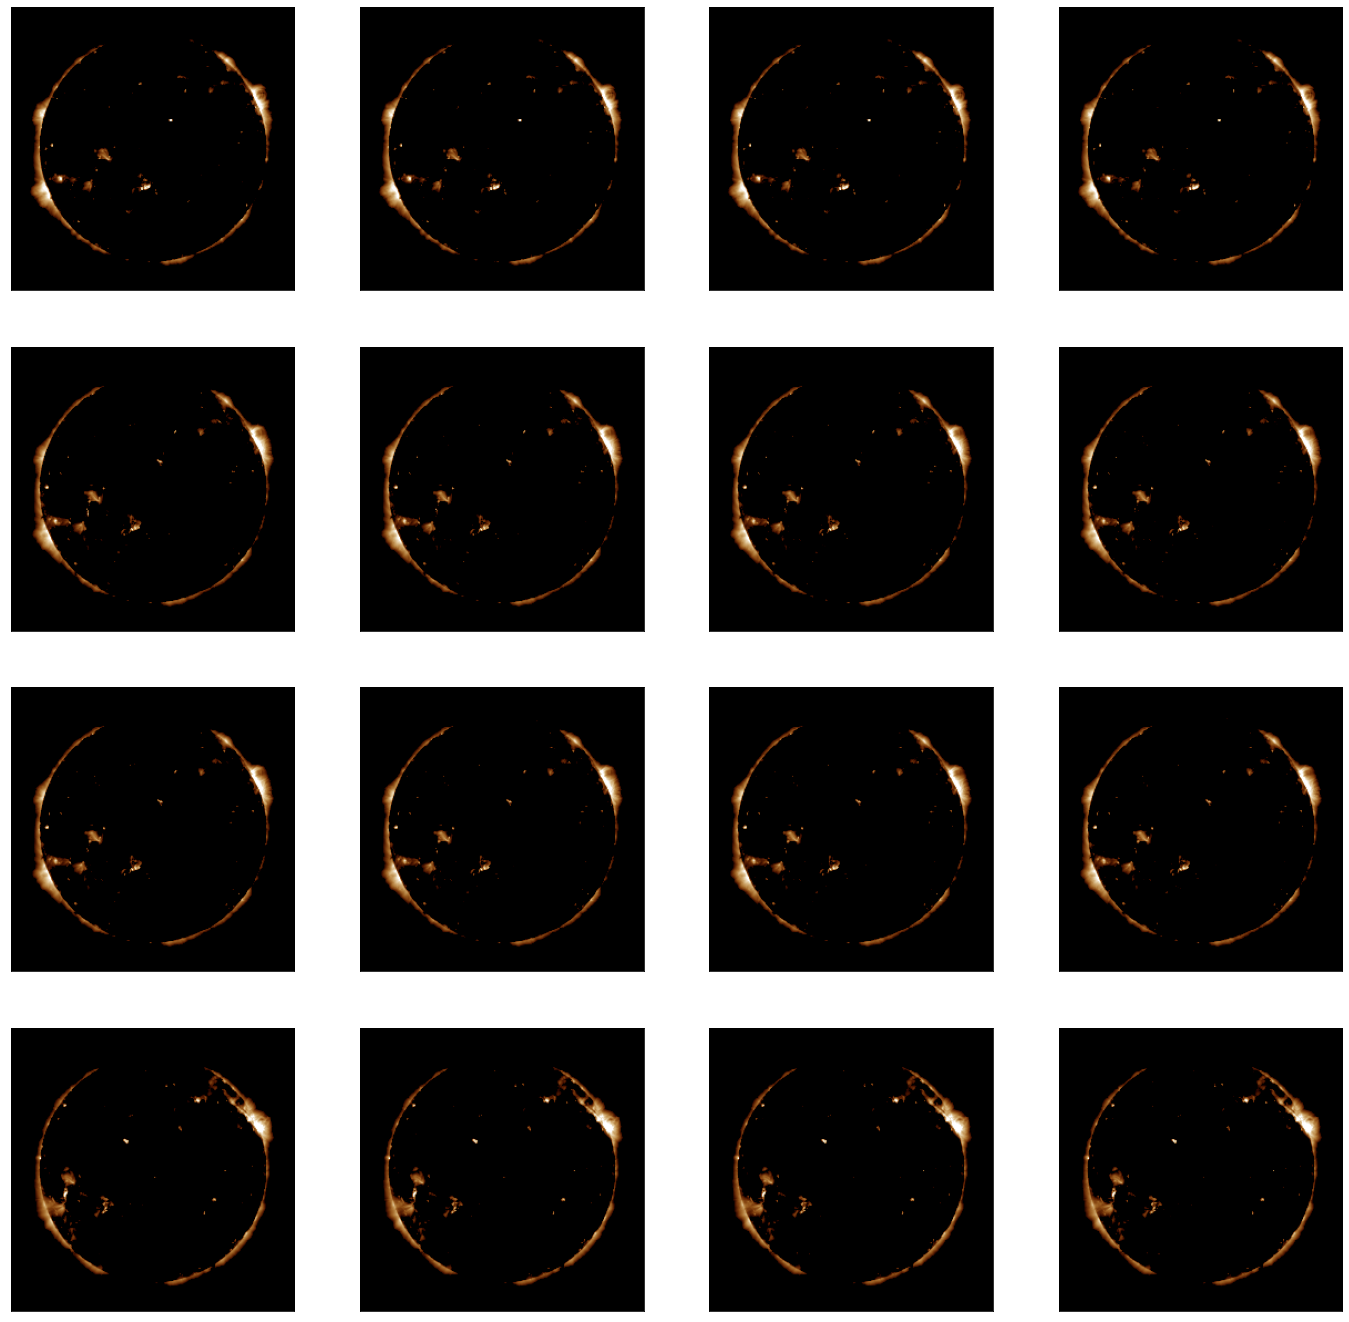

In [16]:
for batch_idx, samples in enumerate(loader):
    X, y = samples
    V = []
    for x in X:
        x = x.permute(1,2,0) # torch to pillow
        x = np.squeeze(x.numpy())
        v = vis(x, channel_to_map(193), get_clip(x, 171))
        V.append(Image.fromarray(v))
    show_grid(V)
    break

In [10]:
loader = SDOMLv2DataModule("/mnt/nas05/astrodata01/astroml_data/sdomlv2_small/sdomlv2_hmi_small.zarr", storage_driver="fs", train_year=["2010"], channel="Bx", train_start="2010-08-27 00:00:00", train_end="2010-08-28 23:59:59", test_start="2010-08-29 00:00:00",
                           test_end="2010-08-29 23:59:59", train_val_split_temporal_chunk_size="1h", prefetch_factor=2, goes_cache_dir="../tmp/new").train_dataloader()


discovered the following zarr directory structure
/
 └── 2010
     ├── Bx (25540, 512, 512) float32
     ├── By (25540, 512, 512) float32
     └── Bz (25540, 512, 512) float32
filtering data between 2010-08-27 00:00:00 and 2010-08-28 23:59:59
found 220 images
discovered the following zarr directory structure
/
 └── 2010
     ├── Bx (25540, 512, 512) float32
     ├── By (25540, 512, 512) float32
     └── Bz (25540, 512, 512) float32
filtering data between 2010-08-29 00:00:00 and 2010-08-29 23:59:59
found 111 images
Selecting groups for train-validation split. Number of groups 48, number of groups for training 34, number of groups for validation 14
splitting Dataset into two subsets. Train size 155, validation size 65


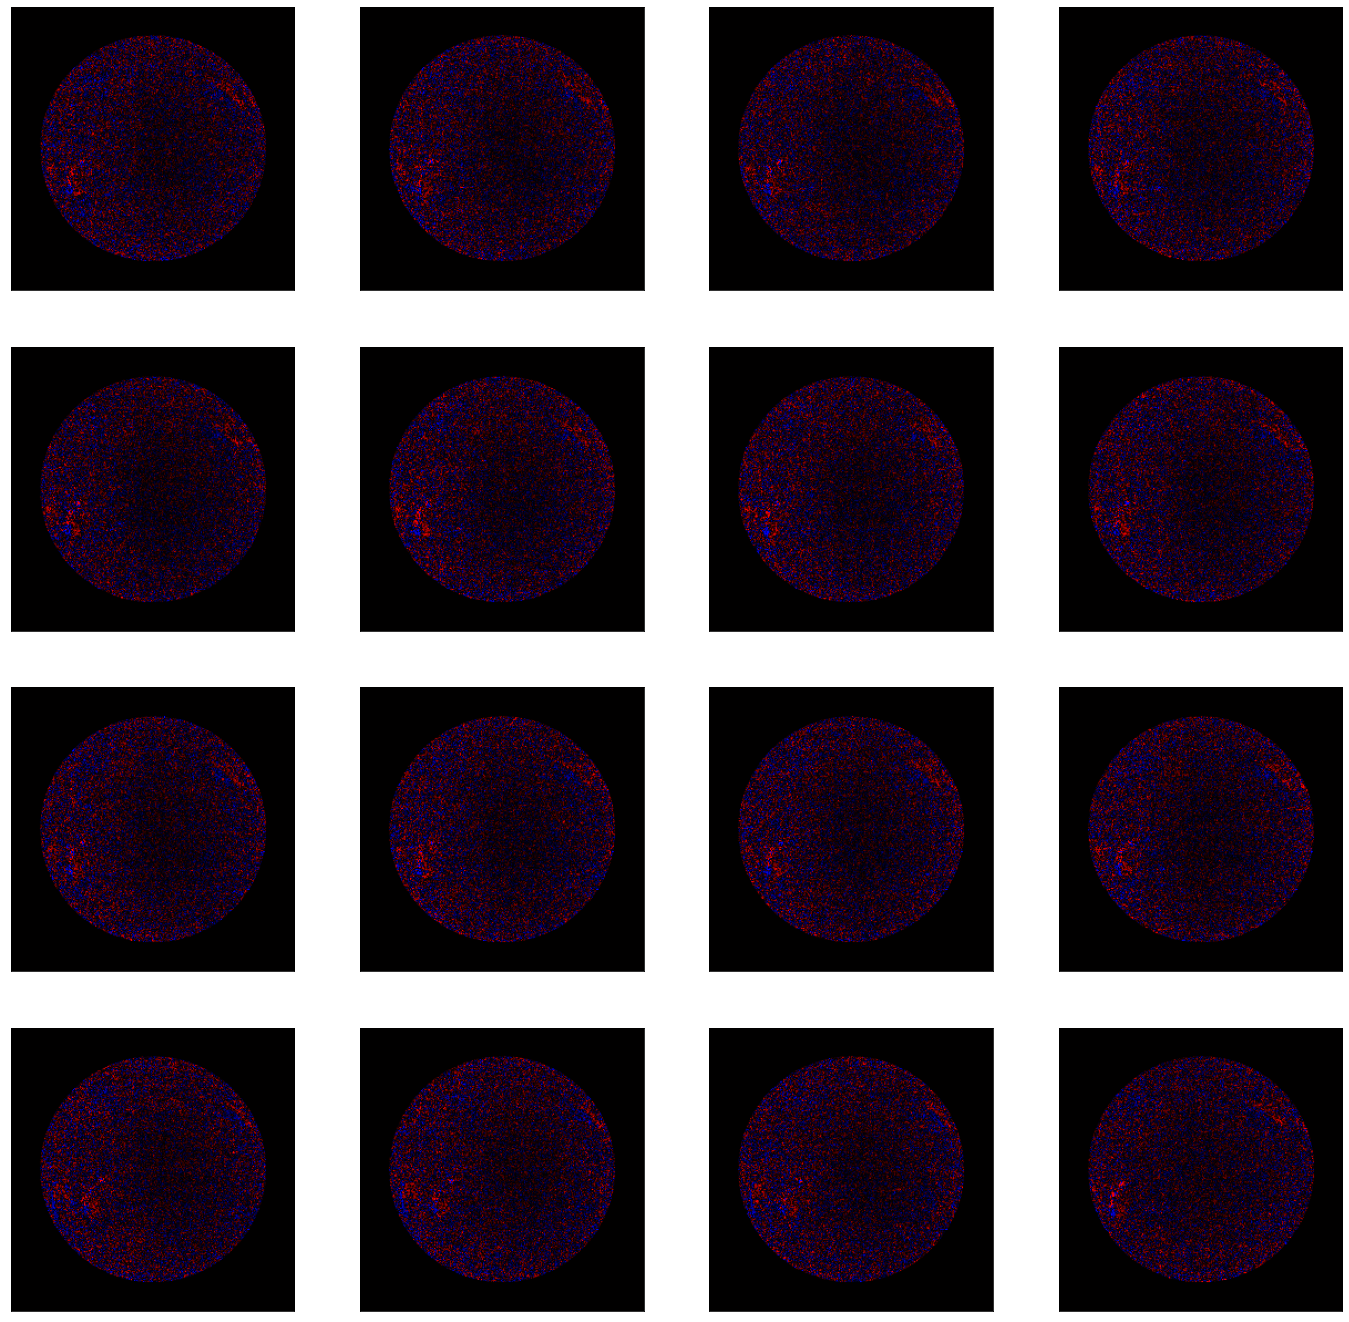

In [11]:
for batch_idx, samples in enumerate(loader):
    X, y = samples
    V = []
    for x in X:
        x = x.permute(1,2,0) # torch to pillow
        x = np.squeeze(x.numpy())
        v = vis(x, channel_to_map("Bx"), get_clip(x, "Bx"))
        V.append(Image.fromarray(v))
    show_grid(V)
    break